# Here are the steps

1. Take a new dataset of spike waveforms and sampling rate
2. Upsample to 50 kHz
3. Cut to 1.5ms around spike time

4. Train a sparse coding model on the data
    - visualize the loss over number of iterations
    - allow options of L1 or L2 penalty, learning rate, number of sparse features 
5. Save model dictionary as npy file




In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
import glob

In [4]:
spike_files = glob.glob("spike_waveforms*.npy")

In [5]:
data = [np.load(f)[()] for f in spike_files]
waveforms = np.concatenate([d["waveforms"] for d in data])
times = np.concatenate([d["times"] for d in data])

In [6]:
original_fs = 30000.0

In [7]:
def resample(waveforms, old_fs, new_fs):
    """
    Params
    waveforms (np.ndarray, N_waveforms x N_samples): waveform dataset
    old_fs (float): sampling rate of waveform data
    new_fs (float): new sampling rate
    """
    original_t = np.linspace(0.0, waveforms.shape[1] / original_fs, waveforms.shape[1])
    center = np.max(original_t) / 2
    
    new_dt = 1 / new_fs
    new_n = np.max(original_t) // new_dt
    
    new_sample_points = np.linspace(0.0, np.max(original_t), int(new_n))
    
    return interp1d(original_t, waveforms, kind="cubic", axis=1)(new_sample_points).astype(waveforms.dtype)
    

In [97]:
wf2 = resample(waveforms[:1000], 30000.0, 100000.0)

In [8]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data.dataset import random_split
from sklearn.decomposition import SparseCoder

class AutoEncoder(nn.Module):
    def __init__(self, dictionary_size, features):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(features, dictionary_size)

    def forward(self, x): 
        x = self.encoder(x)
        return torch.matmul(x, self.encoder.weight)


class SparseSpikeModel(object):
    def __init__(self, n_components):
        self.n_components = n_components
        
    def train(self, data, batch_size=1000, max_iters=100, norm=1,
             learning_rate=1e-3, weight_decay=1e-5):
        self.data = data
        self.model = AutoEncoder(self.n_components, data.shape[1]).cuda()
        
        self._mse = nn.MSELoss()
        self._optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        self._loss = []
        
        for iter_idx in range(max_iters):
            for batch_start in range(0, len(data), batch_size):
                selector = slice(batch_start, batch_start + batch_size)
            
                x = data[selector]
                x = Variable(torch.from_numpy(x)).cuda()
                output = self.model(x)
                
                loss = self._mse(output, x) + self.model.encoder.weight.norm(norm)
                
                self._optimizer.zero_grad()
                loss.backward()
                self._optimizer.step()

            self._loss.append(loss)
            
        return range(max_iters), self._loss

    def encoded(self, data):
        coder = SparseCoder(self.dictionary())
        return coder.transform(data)

    def dictionary(self):
        return self.model.encoder.weight.detach().cpu().numpy()
        

In [9]:
resampled_wfs = resample(waveforms, 30000.0, 50000.0)

In [10]:
ssm = SparseSpikeModel(n_components=40)

In [11]:
iters, loss = ssm.train(resampled_wfs, batch_size=10000, max_iters=30)

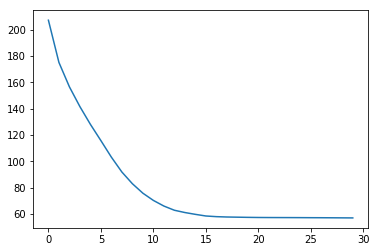

In [12]:
plt.plot(iters, loss)
plt.show()

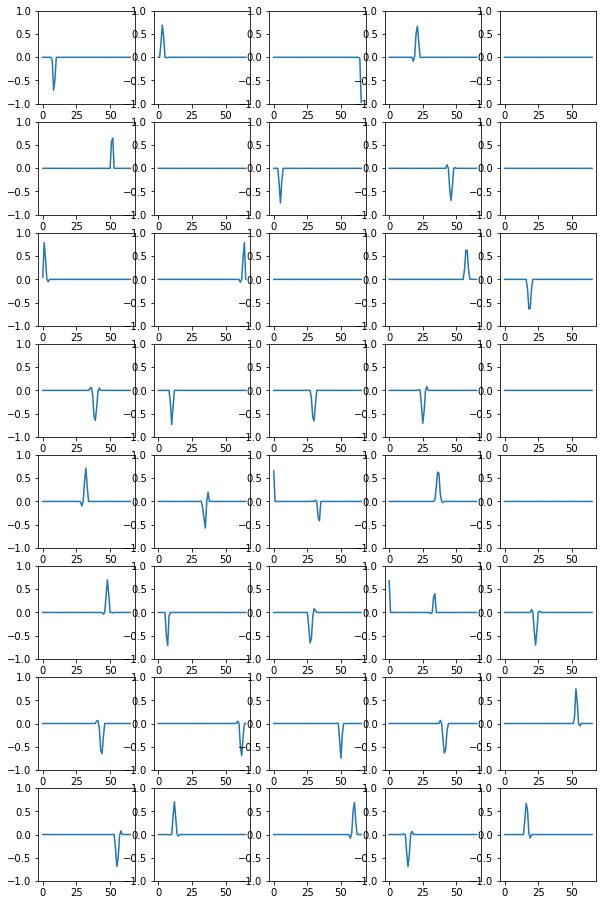

In [13]:
fig, axes = plt.subplots(8, 5, figsize=(10, 16))
for i in range(40):
    ax = np.array(axes).flatten()[i]
    ax.plot(ssm.dictionary()[i, :])
    ax.set_ylim(-1, 1)
plt.show()
plt.close(fig)

In [16]:
spikes = np.load("spike_waveforms-e10.npy")[()]

wfs = resample(spikes["waveforms"], 30000.0, 50000.0)
ts = spikes["times"]

In [17]:
encoded = ssm.encoded(wfs)


/home/kevin/Projects/solid-garbanzo/env/lib/python3.5/site-packages/sklearn/decomposition/dict_learning.py:160: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


In [20]:
pca = PCA(n_components=2).fit(encoded)

In [44]:
selectors = [np.where((ts >= t_start) & (ts < t_start + 0.5 * 60.0))[0]
            for t_start in np.arange(0, np.max(ts), 0.5 * 60.0)]

In [45]:
enc = [encoded[selector] for selector in selectors]

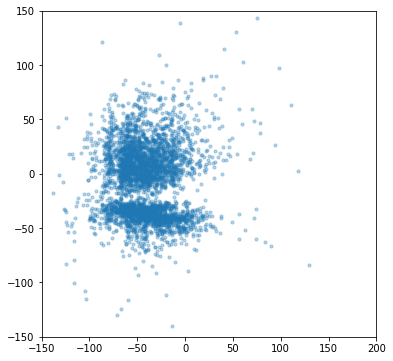

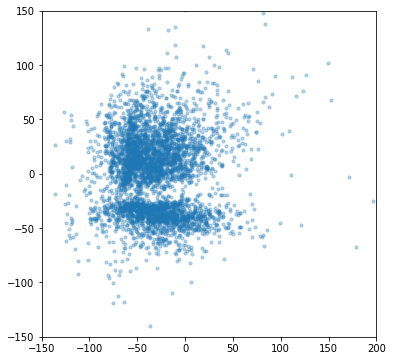

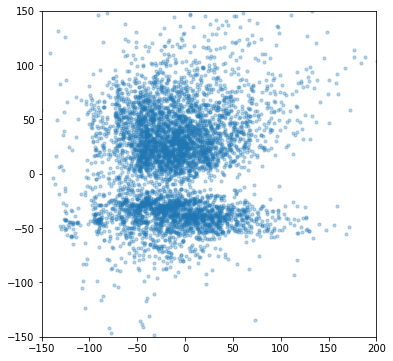

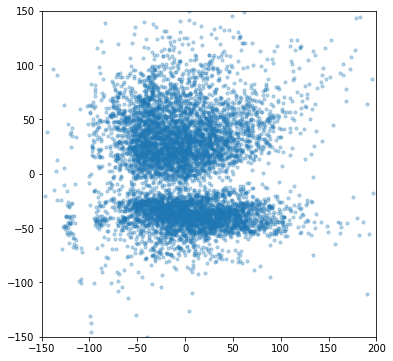

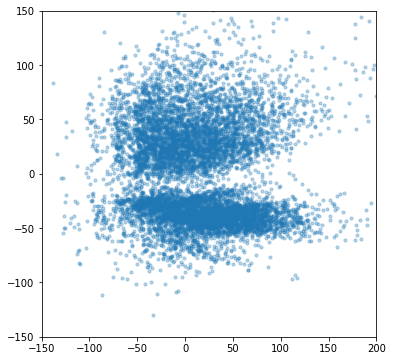

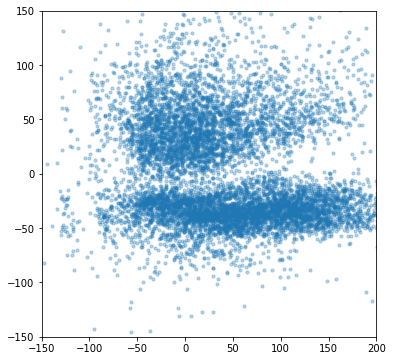

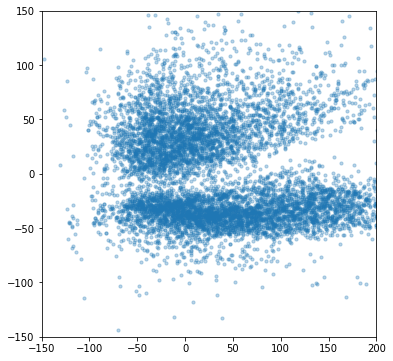

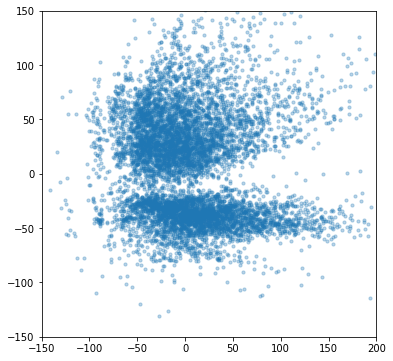

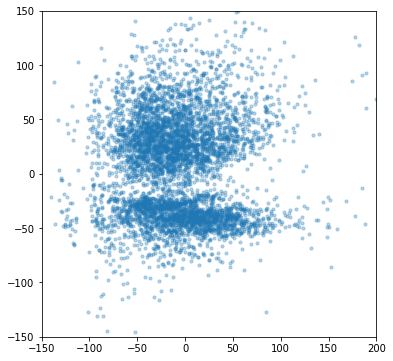

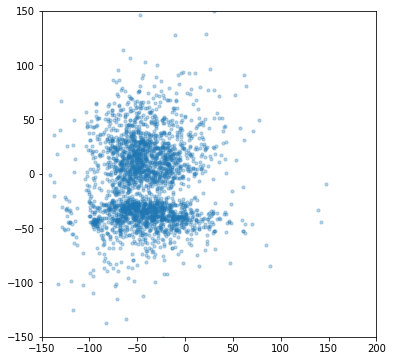

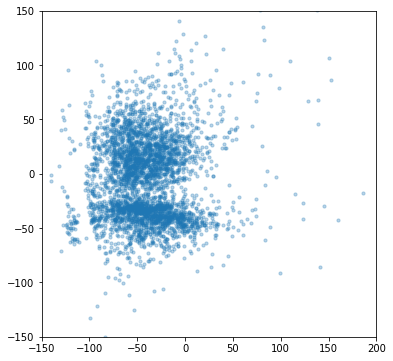

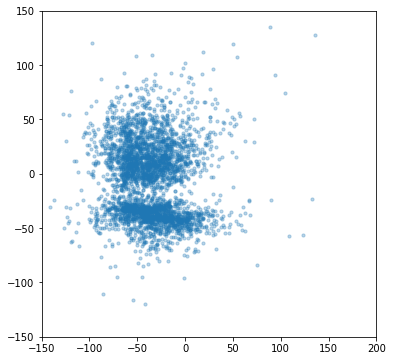

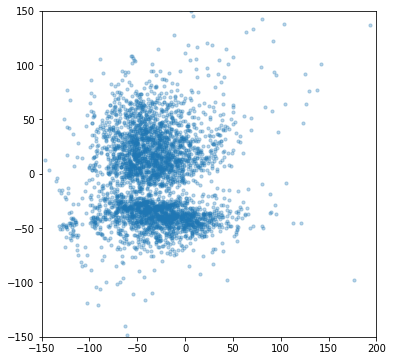

KeyboardInterrupt: 

In [195]:
for en in enc:
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(*pca.transform(en).T, s=10, alpha=0.3)
    plt.xlim(-150, 200)
    plt.ylim(-150, 150)
    plt.show()
    plt.close(fig)

In [46]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML


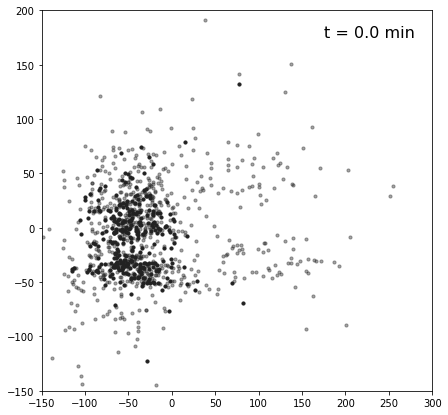

In [55]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(xlim=(-150, 300), ylim=(-150, 200))
prev_scatter = ax.scatter([], [], s=10, color="#222222", alpha=0.4)
scatter=ax.scatter(*pca.transform(enc[0]).T, color="#222222", s=10)
next_scatter = ax.scatter([], [], s=10, color="#222222", alpha=0.4)
frame_label = ax.text(175, 175, "t = 0 min", fontsize=16)

def update(frame_number):
    if frame_number > 0:
        prev_scatter.set_offsets(pca.transform(enc[frame_number-1]))
    scatter.set_offsets(pca.transform(enc[frame_number]))
    if frame_number < len(enc) - 1:
        next_scatter.set_offsets(pca.transform(enc[frame_number + 1]))

    frame_label.set_text("t = {:.1f} min".format(frame_number / 2))
    return scatter,

anim = FuncAnimation(fig, update, frames=len(enc), interval=100)
HTML(anim.to_html5_video())